# **Bitcoin Price Prediction Using RNN, LSTM and Sentiment Analysis on Bitcoin in Stock Market**

### The cryptocurrency market has seen its rise and fall in the past few years. With a variety of coins being exchanged for real money, it is important to know the trend in the coin price. In this project, we built an LSTM network to predict or forecast the prices of Bitcoin.

### Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import datetime as dt

### Loading the dataset used for Price Prediction

In [2]:
data = pd.read_csv("../input/btcusd/BTC-USD.csv",parse_dates=['Date'])

### Understanding the data

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2543,2021-03-09,49288.25000,50982.27344,48386.08594,50025.37500,50025.37500,4.320618e+10
2544,2021-04-09,50009.32422,50545.58203,49548.78125,49944.62500,49944.62500,3.747133e+10
2545,2021-05-09,49937.85938,51868.67969,49538.59766,51753.41016,51753.41016,3.032268e+10
2546,2021-06-09,51769.00391,52700.94141,51053.67969,52633.53516,52633.53516,3.888411e+10
2547,2021-07-09,52561.75781,52850.42578,44672.65625,46889.99609,46889.99609,6.514039e+10


In [5]:
data.shape

(2548, 7)

In [6]:
#Printing the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2548 non-null   datetime64[ns]
 1   Open       2544 non-null   float64       
 2   High       2544 non-null   float64       
 3   Low        2544 non-null   float64       
 4   Close      2544 non-null   float64       
 5   Adj Close  2544 non-null   float64       
 6   Volume     2544 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 139.5 KB


### Checking if there are any missing values

In [7]:
data.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

### Handling with missing values

In [8]:
mean=data['Open'].mean()
data['Open'].fillna(value=mean,inplace=True)
mean=data['High'].mean()
data['High'].fillna(value=mean,inplace=True)
mean=data['Low'].mean()
data['Low'].fillna(value=mean,inplace=True)
mean=data['Close'].mean()
data['Close'].fillna(value=mean,inplace=True)
mean=data['Adj Close'].mean()
data['Adj Close'].fillna(value=mean,inplace=True)
mean=data['Volume'].mean()
data['Volume'].fillna(value=mean,inplace=True)

### Rechecking after dealing with missing values

In [9]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Splitting the data into Train and Test sets

In [10]:
#Setting The training set ratio
training_ratio = 80

#Calculating the test set ratio
test_ratio = 20

#Rounding the training set length to avoid fractions
training_len = round(len(data)*(training_ratio/100))

#Setting the Test set length
test_len = round(len(data)-training_len)

#Splitting the data based on the calculated lengths
dataset_train = data.head(training_len)
dataset_test = data.tail(test_len)

#Printing the shapes of training and test sets

print("Shape Of Training Set :", dataset_train.shape)
print("Shape Of Test Set :", dataset_test.shape)

Shape Of Training Set : (2038, 7)
Shape Of Test Set : (510, 7)


### Understanding the splitted data

In [11]:
print(dataset_test.head(10))
print(dataset_train.tail(10))

           Date         Open         High          Low        Close  \
2038 2020-04-16  6640.454102  7134.450684  6555.504395  7116.804199   
2039 2020-04-17  8804.049001  9054.956675  8531.045625  8821.453475   
2040 2020-04-18  7092.291504  7269.956543  7089.247070  7257.665039   
2041 2020-04-19  7260.922363  7280.521973  7167.054688  7189.424805   
2042 2020-04-20  7186.873535  7240.290527  6835.502930  6881.958496   
2043 2020-04-21  6879.784180  6934.551758  6834.442383  6880.323242   
2044 2020-04-22  6879.440430  7145.865723  6867.781738  7117.207520   
2045 2020-04-23  7121.306152  7491.785156  7081.594727  7429.724609   
2046 2020-04-24  7434.181641  7574.195801  7434.181641  7550.900879   
2047 2020-04-25  7550.482910  7641.363770  7521.672363  7569.936035   

        Adj Close        Volume  
2038  7116.804199  4.678324e+10  
2039  8821.453475  1.338296e+10  
2040  7257.665039  3.244719e+10  
2041  7189.424805  3.131121e+10  
2042  6881.958496  3.774711e+10  
2043  6880.323

In [12]:
#Setting Date column as Index
dataset_train.set_index('Date', inplace = True)

### Feature Scaling

In [13]:
sc = MinMaxScaler(feature_range = (0,1))

def bit_pre_process(raw_data , seq_len, column = 1):
  
  #Select the feature/column 
  data = raw_data.iloc[:, column].values
  data = data.reshape(-1, 1)
  
  #Feature Scaling
  data = sc.fit_transform(data)
  
  #Making sequences
  
  X = []
  y = []

  for i in range(seq_len, len(data)):
      X.append(data[i-seq_len:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  # Reshaping
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

### Sequencing

In [14]:
#Setting the sequence length 
sequence_length = 60

#Choosing the idex of the Close column
column_index= 3

#Preprocessing the training set
X_train, y_train = bit_pre_process(dataset_train , sequence_length, column_index)

In [15]:
X_train.shape

(1978, 60, 1)

In [16]:
y_train.shape

(1978,)

### Building the Recurrent Neural Network model using LSTM

In [17]:
#Initialising the RNN
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

### Compiling the RNN

In [18]:
#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'])

In [19]:
#Fitting the RNN to the Training set and training the RNN
regressor.fit(X_train, y_train, epochs = 50, batch_size = 50)

Epoch 1/50
40/40 [==============================] - 10s 110ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1016
Epoch 2/50
40/40 [==============================] - 4s 111ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0371
Epoch 3/50
40/40 [==============================] - 4s 110ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0331
Epoch 4/50
40/40 [==============================] - 4s 111ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0300
Epoch 5/50
40/40 [==============================] - 4s 112ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0313
Epoch 6/50
40/40 [==============================] - 4s 110ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0268
Epoch 7/50
40/40 [==============================] - 5s 116ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0259
Epoch 8/50
40/40 [==============================] - 4s 112ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0268
Epoch 9/50
40/40 [==============================] - 4s 110ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0260
Epoch 10/50
40/40 

### Preparing test data

In [20]:
#Displaying the dataset
dataset_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2038,2020-04-16,6640.454102,7134.450684,6555.504395,7116.804199,7116.804199,4.678324e+10
2039,2020-04-17,8804.049001,9054.956675,8531.045625,8821.453475,8821.453475,1.338296e+10
2040,2020-04-18,7092.291504,7269.956543,7089.247070,7257.665039,7257.665039,3.244719e+10
2041,2020-04-19,7260.922363,7280.521973,7167.054688,7189.424805,7189.424805,3.131121e+10
2042,2020-04-20,7186.873535,7240.290527,6835.502930,6881.958496,6881.958496,3.774711e+10


In [21]:
#Setting the Date column as Index to the dataset
dataset_test.set_index('Date', inplace = True)

In [22]:
dataset_test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-16,6640.454102,7134.450684,6555.504395,7116.804199,7116.804199,4.678324e+10
2020-04-17,8804.049001,9054.956675,8531.045625,8821.453475,8821.453475,1.338296e+10
2020-04-18,7092.291504,7269.956543,7089.247070,7257.665039,7257.665039,3.244719e+10
2020-04-19,7260.922363,7280.521973,7167.054688,7189.424805,7189.424805,3.131121e+10
2020-04-20,7186.873535,7240.290527,6835.502930,6881.958496,6881.958496,3.774711e+10


In [23]:
dataset_test.shape

(510, 6)

In [24]:
test_set = pd.concat((dataset_train.tail(sequence_length), dataset_test), axis = 0)

In [25]:
test_set.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-16,9889.179688,10053.968750,9722.386719,9934.433594,9934.433594,4.337478e+10
2020-02-17,9936.560547,9938.815430,9507.637695,9690.142578,9690.142578,4.599830e+10
2020-02-18,9691.230469,10161.935550,9632.382813,10141.996090,10141.996090,4.727102e+10
2020-02-19,10143.798830,10191.675780,9611.223633,9633.386719,9633.386719,4.699202e+10
2020-02-20,9629.325195,9643.216797,9507.900391,9608.475586,9608.475586,4.492526e+10
2020-02-21,9611.782227,9723.014648,9589.743164,9686.441406,9686.441406,4.093055e+10
2020-02-22,9687.707031,9698.231445,9600.728516,9663.181641,9663.181641,3.583803e+10
2020-02-23,9663.318359,9937.404297,9657.791016,9924.515625,9924.515625,4.118519e+10
2020-02-24,9921.583008,9951.746094,9537.042969,9650.174805,9650.174805,4.508050e+10


In [26]:
test_set.shape

(570, 6)

In [27]:
#Preprocessing the test data
x_test, y_true = bit_pre_process(test_set , sequence_length, column_index)

In [28]:
x_test.shape

(510, 60, 1)

In [29]:
y_true.shape

(510,)

### Finding the Error values

In [30]:
score=regressor.evaluate(x_test,y_true)
loss=score[0]
mse=score[1]
mae=score[2]

16/16 [==============================] - 2s 31ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0252 


In [31]:
loss

0.0013033972354605794

In [32]:
mse

0.0013033972354605794

In [33]:
mae

0.025189923122525215

### Prediction

In [34]:
#Predicting the closing price of the test data
predicted_stock_price = regressor.predict(x_test)

In [35]:
# #Inversing the scaled values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [36]:
#Inversing the scaled actual prices from test data
real_stock_price = sc.inverse_transform(y_true.reshape(-1, 1))

### Visualising the Prediction

In [37]:
# A Method to plot predicted pirce vs Actual price
def plot_predictions(real_stock_price, predicted_stock_price, title, x_label, y_label):
    plt.plot(real_stock_price, color = 'green', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

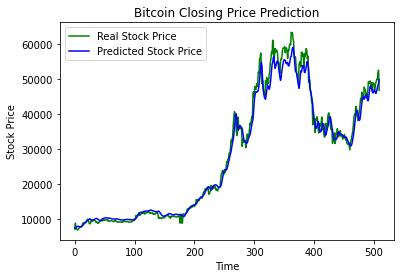

In [38]:
#Plotting real_stock_pric vs predicted_stock_price
plot_predictions(real_stock_price, predicted_stock_price, "Bitcoin Closing Price Prediction", "Time", "Stock Price")

### Comparing the Predicted and Actual prices

In [39]:
dataset_test['Predicted_Close'] = predicted_stock_price

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
compare = dataset_test[['Open','Close','Predicted_Close' ]]

In [41]:
compare.head(20)

,Open,Close,Predicted_Close
Date,,,
2020-04-16,6640.454102,7116.804199,7486.604004
2020-04-17,8804.049001,8821.453475,7439.546387
2020-04-18,7092.291504,7257.665039,7536.275391
2020-04-19,7260.922363,7189.424805,7708.208984
2020-04-20,7186.873535,6881.958496,7863.094238
2020-04-21,6879.784180,6880.323242,7934.656738
2020-04-22,6879.440430,7117.207520,7914.169434
2020-04-23,7121.306152,7429.724609,7843.607422
2020-04-24,7434.181641,7550.900879,7782.990723


## **Sentiment Analysis**

### Loading the Tweet data

In [42]:
import pandas as pd
tweet=pd.read_csv('../input/bitcoin-tweets-20160101-to-20190329/tweets.csv', sep=';'
                  ,usecols=["timestamp", "text"])
tweet.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,timestamp,text
0,2019-05-27 11:49:14+00,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27 11:49:18+00,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27 11:49:06+00,Another Test tweet that wasn't caught in the s...
3,2019-05-27 11:49:22+00,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27 11:49:23+00,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


### Loading the dataset

In [43]:
stock=pd.read_csv('../input/btcusd/BTC-USD.csv')
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [44]:
stock=stock[['Date','Close']]
stock.head()

,Date,Close
0,17-09-2014,457.334015
1,18-09-2014,424.440002
2,19-09-2014,394.795990
3,20-09-2014,408.903992
4,21-09-2014,398.821014


### Finding variations in prices for each day

In [45]:
stock['Price Change']=stock['Close'].diff(periods=1)
stock.head()

,Date,Close,Price Change
0,17-09-2014,457.334015,NaN
1,18-09-2014,424.440002,-32.894013
2,19-09-2014,394.795990,-29.644012
3,20-09-2014,408.903992,14.108002
4,21-09-2014,398.821014,-10.082978


### Removing rows with null values

In [46]:
stock = stock[stock['Price Change'].notna()]
stock.head()

,Date,Close,Price Change
1,18-09-2014,424.440002,-32.894013
2,19-09-2014,394.795990,-29.644012
3,20-09-2014,408.903992,14.108002
4,21-09-2014,398.821014,-10.082978
5,22-09-2014,402.152008,3.330994


### Assigning sentiment to the data

In [47]:
def getAnalysis(score):
    if score < 0:
        return 'Decrease'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Increase'
stock['Sentiment'] = stock['Price Change'].apply(getAnalysis )
stock.head()

,Date,Close,Price Change,Sentiment
1,18-09-2014,424.440002,-32.894013,Decrease
2,19-09-2014,394.795990,-29.644012,Decrease
3,20-09-2014,408.903992,14.108002,Increase
4,21-09-2014,398.821014,-10.082978,Decrease
5,22-09-2014,402.152008,3.330994,Increase


In [48]:
stock=stock[['Date','Sentiment']]
stock.head()

,Date,Sentiment
1,18-09-2014,Decrease
2,19-09-2014,Decrease
3,20-09-2014,Increase
4,21-09-2014,Decrease
5,22-09-2014,Increase


In [49]:
stock.Sentiment.value_counts()

Increase    1382
Decrease    1157
Neutral        1
Name: Sentiment, dtype: int64

In [50]:
stock.Date=pd.to_datetime(stock.Date)
stock.head()

,Date,Sentiment
1,2014-09-18,Decrease
2,2014-09-19,Decrease
3,2014-09-20,Increase
4,2014-09-21,Decrease
5,2014-09-22,Increase


In [51]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540 entries, 1 to 2547
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2540 non-null   datetime64[ns]
 1   Sentiment  2540 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 59.5+ KB


In [52]:
tweet=tweet[['timestamp','text']]
tweet.head()

,timestamp,text
0,2019-05-27 11:49:14+00,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27 11:49:18+00,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27 11:49:06+00,Another Test tweet that wasn't caught in the s...
3,2019-05-27 11:49:22+00,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27 11:49:23+00,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [53]:
tweet[['Date','Time']] = tweet.timestamp.str.split(expand=True)
tweet.head()

,timestamp,text,Date,Time
0,2019-05-27 11:49:14+00,È appena uscito un nuovo video! LES CRYPTOMONN...,2019-05-27,11:49:14+00
1,2019-05-27 11:49:18+00,Cardano: Digitize Currencies; EOS https://t.co...,2019-05-27,11:49:18+00
2,2019-05-27 11:49:06+00,Another Test tweet that wasn't caught in the s...,2019-05-27,11:49:06+00
3,2019-05-27 11:49:22+00,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,2019-05-27,11:49:22+00
4,2019-05-27 11:49:23+00,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,2019-05-27,11:49:23+00


In [54]:
tweet=tweet[['Date','text']]
tweet.head()

,Date,text
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27,Another Test tweet that wasn't caught in the s...
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [55]:
tweet.Date=pd.to_datetime(tweet.Date)
tweet.head()

,Date,text
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...
2,2019-05-27,Another Test tweet that wasn't caught in the s...
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


### Merging the tweet data and bitcoin dataset

In [56]:
data=tweet.merge(stock, on='Date', how='inner')
data.isnull().sum()

Date           0
text         721
Sentiment      0
dtype: int64

In [57]:
data=data.dropna()
data.isnull().sum()

Date         0
text         0
Sentiment    0
dtype: int64

In [58]:
data.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Increase
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Increase
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Increase
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Increase
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Increase


In [59]:
round(data.Sentiment.value_counts()*100/len(data),2)

Decrease    52.09
Increase    47.91
Neutral      0.00
Name: Sentiment, dtype: float64